In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [74]:
import matplotlib.pyplot as plt

# Read data from the provided CSV
Using the provided function from pandas library: read_csv

In [30]:
train_data=pd.read_csv('/kaggle/input/titanic/train.csv')
test_data=pd.read_csv('/kaggle/input/titanic/test.csv')

# An overview of our available data
## Train data and test data

In [31]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [32]:
train_data.shape

(891, 12)

In [33]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data Cleanup
## Before inserting the data into our machine learning model, we need to fill in all the blanks and normalize all the columns.

## Important function:
- fillna
- mean
- mode
- median
- apply and lambda
- map
- concat
- drop
- get_dummy

In [34]:
def clean_data(df):
    res=df
    res['Age'].fillna(res['Age'].mean(),inplace=True)
    res['Embarked'].fillna(res['Embarked'].mode(),inplace=True)
    res['Fare'].fillna(res['Fare'].mean(),inplace=True)
    res['Ticket']=res['Ticket'].apply(lambda x:get_head_ticket(x))
    
    res['Age']=res['Age']/100
    res['SibSp']=res['SibSp']/11
    res['Parch']=res['Parch']/7
    res['Fare']+=1
    res['Fare']=np.log(res['Fare'])
    #res['Pclass']=(res['Pclass']-1)/2
    res['Pclass']=res['Pclass'].map({1:'First',2:'Second',3:'Third'})
    
    addition=pd.get_dummies(df[['Embarked','Sex','Ticket','Pclass']])
    res=pd.concat([df,addition],axis=1)
    
    #res['Sex']=res['Sex'].map({'female':1,'male':0})
    
    res=res.drop(columns=['Embarked','PassengerId','Name','Cabin','Ticket','Sex','Pclass'])
    
    
    return res

def get_head_ticket(str):
    if(len(str.split())==2):
        return str.split()[0]
    else:
        return ''

In [35]:
cleaned_train=clean_data(train_data)
cleaned_test=clean_data(test_data)

# Viewing our 'cleaned' train and test data
## There will be many advanced data cleaning process in the our upcoming seminars so stay tuned :))

In [36]:
#cleaned_train.head()
#cleaned_train.shape
cleaned_train.isnull().sum()

Survived             0
Age                  0
SibSp                0
Parch                0
Fare                 0
Embarked_C           0
Embarked_Q           0
Embarked_S           0
Sex_female           0
Sex_male             0
Ticket_              0
Ticket_A./5.         0
Ticket_A.5.          0
Ticket_A/4           0
Ticket_A/4.          0
Ticket_A/5           0
Ticket_A/5.          0
Ticket_A/S           0
Ticket_A4.           0
Ticket_C             0
Ticket_C.A.          0
Ticket_C.A./SOTON    0
Ticket_CA            0
Ticket_CA.           0
Ticket_F.C.          0
Ticket_F.C.C.        0
Ticket_Fa            0
Ticket_P/PP          0
Ticket_PC            0
Ticket_PP            0
Ticket_S.C./A.4.     0
Ticket_S.C./PARIS    0
Ticket_S.O./P.P.     0
Ticket_S.O.C.        0
Ticket_S.O.P.        0
Ticket_S.P.          0
Ticket_S.W./PP       0
Ticket_SC            0
Ticket_SC/AH         0
Ticket_SC/PARIS      0
Ticket_SC/Paris      0
Ticket_SCO/W         0
Ticket_SO/C          0
Ticket_SOTO

## Since there may be people in the test data that have tickets type that doesn't appear in the training data and vice versa. Therefore, we need to ensure that both dataframes have the same set of columns and in the same order.

In [37]:
for cols in cleaned_test.columns:
    if cols not in cleaned_train.columns:
        cleaned_train[cols]=[0 for j in range(cleaned_train.shape[0])]

for cols in cleaned_train.columns:
    if cols not in cleaned_test.columns and cols!='Survived':
        cleaned_test[cols]=[0 for j in range(cleaned_test.shape[0])]
        
cleaned_test = cleaned_test.reindex(cleaned_train.drop(columns='Survived').columns, axis=1)

# Create our data points and sample outputs for each data points
## X: Input Data Points
## y: Sample Outputs

In [38]:
X=cleaned_train.drop(columns='Survived')
y=cleaned_train['Survived']
X.shape,y.shape

((891, 60), (891,))

# Create out train datasets and testing datasets
## Why do we need to split between training datasets and validation datasets
sklearn is a valuable library for Shallow Machine Learning with many ML models and utility functions.
Example: train_test_split

In [39]:
from sklearn.model_selection import train_test_split

X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=10,test_size=0.2)

# Import necessary libraries (Tensorflow and Keras)

## Tensorflow
TensorFlow is an end-to-end open-source deep learning framework developed by Google and released in 2015. It is known for documentation and training support, scalable production and deployment options, multiple abstraction levels, and support for different platforms, such as Android.

## Keras
Keras is an effective high-level neural network Application Programming Interface (API) written in Python. This open-source neural network library is designed to provide fast experimentation with deep neural networks, and it can run on top of CNTK, TensorFlow, and Theano.

In [40]:
import keras
import tensorflow as tf

In [41]:
from keras.models import Sequential
from keras.layers import InputLayer,Dense

# Setting up the hyperparameters of out Neural Network
## Parameters
## Hyperparameters

In [60]:
input_layers=X_val.shape[1]
output_layers=1
hidden_layers=[64,16,4,2]

# Creating layers for our Neural Network
## Activation Function
- ReLU
- Sigmoid
- Tanh
- Linear

In [61]:
model=Sequential()
model.add(InputLayer(input_shape=(input_layers,)))
for num in hidden_layers:
    model.add(Dense(units=num,activation='relu'))
model.add(Dense(units=output_layers,activation='sigmoid'))

In [62]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                3904      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 68        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 10        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 3         
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


# Compiling our Model
## Parameters of the function
- Loss Function
- Optimizer
- Metrics

In [63]:
model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

# Fitting

In [64]:
history=model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=50,batch_size=10)

Epoch 1/50
72/72 [==============================] - 1s 5ms/step - loss: 0.6632 - accuracy: 0.6067 - val_loss: 0.6172 - val_accuracy: 0.6536
Epoch 2/50
72/72 [==============================] - 0s 2ms/step - loss: 0.6159 - accuracy: 0.6067 - val_loss: 0.5701 - val_accuracy: 0.6536
Epoch 3/50
72/72 [==============================] - 0s 2ms/step - loss: 0.5857 - accuracy: 0.6194 - val_loss: 0.5382 - val_accuracy: 0.7207
Epoch 4/50
72/72 [==============================] - 0s 2ms/step - loss: 0.5654 - accuracy: 0.7219 - val_loss: 0.5187 - val_accuracy: 0.7933
Epoch 5/50
72/72 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.7767 - val_loss: 0.5125 - val_accuracy: 0.8212
Epoch 6/50
72/72 [==============================] - 0s 2ms/step - loss: 0.5453 - accuracy: 0.7921 - val_loss: 0.5109 - val_accuracy: 0.8156
Epoch 7/50
72/72 [==============================] - 0s 2ms/step - loss: 0.5403 - accuracy: 0.8090 - val_loss: 0.4906 - val_accuracy: 0.8268
Epoch 8/50
72/72 [==

In [72]:
test_loss, test_acc = model.evaluate(X_val, y_val)

6/6 [==============================] - 0s 2ms/step - loss: 0.4159 - accuracy: 0.8324


# Seeing the Training Process
## Accuracy


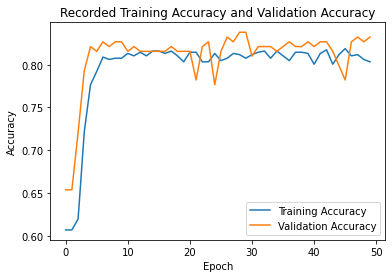

In [80]:
plt.title('Recorded Training Accuracy and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])

## Loss

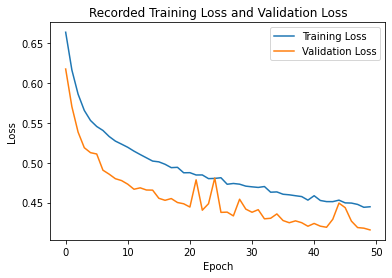

In [82]:
plt.title('Recorded Training Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])

# Making predictions

In [83]:
model.predict(cleaned_test).round().astype(int).reshape(-1)

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [57]:
predictions=model.predict(cleaned_test).round().astype(int).reshape(-1)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
